# An Introduction to Bayesian Optimization

_Prepared by Ritz Aguilar (Thrill Summer School 2024, France)_

References
1. [F. Nogueira (2014), Bayesian Optimization: Open source constrained global optimization tool for Python](https://bayesian-optimization.github.io/BayesianOptimization)
2. [E. Lee (2023), Bayesian Optimization with Python](https://drlee.io/bayesian-optimization-with-python-b544255757d3)
3. [S. V. Kalinin (2023), Bayesian Optimization for Automated Experiments](https://github.com/SergeiVKalinin/AutomatedExperiment_Summer2023)
4. https://distill.pub/2020/bayesian-optimization/

#### Objectives
- Introduce the fundamental concepts and purpose of Bayesian Optimization (BO).
- Learn about surrogate models for BO.
- Learn some of the different types of acquisition functions used in BO.

#### Definition
**Bayesian Optimization** is a global optimization method used for optimizing black-box functions that are expensive to evaluate, common in control and machine learning applications.


- **Problem**: We have an objective function $f(x)$, but we don't know its form and each evaluation is costly and/or noisy as in real-world problems. Our goal is to find the minimum of this noisy function: 
\begin{align}x^* = arg \min_x f(x).\end{align}

- **Solution**: Use a probabilistic surrogate model (e.g., Gaussian Process) to approximate $f(x)$ and an acquisition function to decide where to evaluate next.


#### Key Components
1. **Objective Function**: The ground truth function we want to learn/optimize. This is an unknown function, i.e. a black-box.
2. **Surrogate Model**: Estimates the objective function by using a surrogate model, i.e. a probabilistic model. Gaussian Processes (GP) are often used as they provide both mean prediction and uncertainty for each point.
3. **Acqusition/Utility Functions**: Serves as a guide for deciding which point in the search space to evaluate next based on the current model of the objective function.

##### Set up the environment; import all libraries

In [1]:
## Uncomment to install the following library in your environment
# !pip install scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

## Gaussian Processes (GP) Regression

#### Exercise 1: GP Fitting

We will fit a GP to a noisy sine function and visualize the predictions. 

#### Define a simple function we want to optimize (objective function)

In [22]:
np.random.seed(42)

def f(x, noise_level=0.01):
    return np.exp(-x) * np.sin(4 * x) + np.random.randn(*x.shape) * noise_level

Now, we sample points from the objective function which is unknown to us. In the lab, we can only measure a few points (often noisy) and infer the unknown function from points (priors).

#### Noise-free case

In [23]:
noise_level = 0 # we first set this to zero
X_train = np.random.uniform(-2, 2, 10).reshape(-1, 1)
y_train = f(X_train, noise_level=noise_level) # note that you can also first set the noise to zero

Define a Gaussian Process model with combined effect of multiple kernels and then fit the model to the sampled data.

In [18]:
kernel = C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=noise_level**2)

# Fit the GP model to the sampled data
gp.fit(X, Y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

#### Predict at new data points

In [19]:
# Predict at new data points
X_new = np.linspace(-2, 2, 100).reshape(-1, 1)
Y_pred, sigma = gp.predict(X_new, return_std=True)

Above: _Y_pred_ is the mean prediction and _sigma_ would be the standard deviation.

#### Plot the result for a single iteration

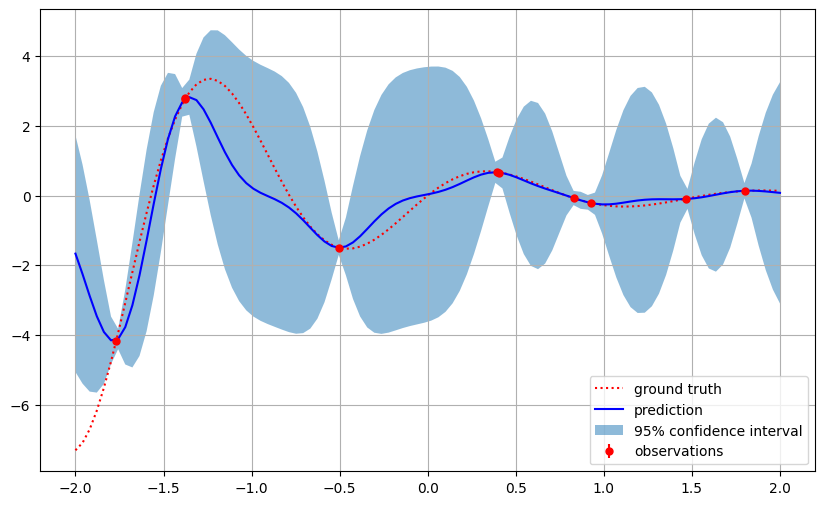

In [24]:
# Plotting the GP predictions
plt.figure(figsize=(10, 6))
plt.plot(X_new, f(X_new, noise_level=0), 'r:', label=r'ground truth')

# Flatten X and Y to 1D
plt.errorbar(X.flatten(), Y.flatten(), yerr=noise_level, fmt='r.', markersize=10, label='observations')
plt.plot(X_new, Y_pred, 'b-', label='prediction')
plt.fill_between(X_new.ravel(), 
                 Y_pred - 1.96 * sigma, 
                 Y_pred + 1.96 * sigma, 
                 alpha=0.5, 
                 label='95% confidence interval')

plt.grid()
plt.legend(loc='lower right')  
plt.show()

**Exercise 1.1** Adjust the number of data points to see how it affects the GP’s confidence.

##### Sol 1.1

**Exercise 1.2** Play around with different noise levels and see how it affects the measured value.

##### Sol 1.2

#### Bayesian Optimization Loop

References: 
1. https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html
2. https://sassafras13.github.io/BayesianOptimization/

To optimize the objective function iteratively, we follow the steps outlined below for $t = 1, 2, \ldots, T$:


1. **Construct a Probabilistic Model**: Start with the observations $x_i, y_i = f(x_i)$ for $i = 1:t$ to build a probabilistic model of the objective function $f$. This involves integrating over all possible true functions using GP regression.

2. **Select the Next Sampling Point**: Choose the next point to sample, $x_{t+1}$, by finding the maximum of the acquisition function $u$ based on the current observations:
   $x_{t+1} = \arg \max_x u(x)$.
   This step helps balance exploration and exploitation by leveraging uncertainty in the model.

3. **Sample the Objective Function**: Evaluate the objective function at the selected point, obtaining $y_{t+1} = f(x_{t+1})$. Add this new observation to the existing dataset.

4. **Update the Surrogate Model**: Update the surrogate function $g(\cdot)$ to incorporate the newly sampled point $(x_{t+1}, y_{t+1})$.

Now, let's delve into the mathematical details of this approach.


In [8]:
# We first put everything together and neatly into functions.

def objective_function():
    kernel = C(params[0], (1e-3, 1e3)) * RBF(params[1], (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, y_train)
    predictions = gp.predict(X_test)
    return -mean_squared_error(y_test, predictions)

kernel = C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit the GP model to the sampled data
gp.fit(X, Y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

## Testing out Different Kernels

## Extensions

There are other Python-based libraries offering more streamlined approaches to perform BO. These include:
- $\texttt{skopt}$ - built on top of $\texttt{numpy}$, $\texttt{scipy}$, and $\texttt{scikit-learn}$
- $\texttt{bayesian-optimization}$ - pure Python implementation of BO with GP
- $\texttt{gpax}$ - built on top of $\texttt{NumPyro}$ and $\texttt{JAX}$, allows for running on GPU; better to create a new environment for this one

In [9]:
# !pip install bayesian-optimization